# Imports

In [152]:
import pulp
import matplotlib.pyplot as plt
import pandas as pd

In [154]:
# Import data from Excel

technologies_df = pd.read_excel("single_region_model_inputs.xlsx", sheet_name = "Sheet1")
years_df = pd.read_excel("single_region_model_inputs.xlsx", sheet_name = "Sheet2")

# Additional modelling data
carbon_tax = 45 # in $/tCO2
renewables_subsidy = 0.2 # in fraction of Capex subsidised
limited_area = 20 # in km2

In [156]:
# Visualise Technologies Data
technologies = technologies_df["Technologies"].tolist()
technologies_df = technologies_df.set_index("Technologies")
technologies_df.head()

,Initial_Capacity_GW,Capacity_Factor,Efficiency,Capex_USDperGW,Variable_Opex_USDperGWh,Fixed_Opex_USDperGWhperyear,Land_Use_km2perGW,Emissions_Factor_tCO2perGWh_th
Technologies,,,,,,,,
fossil,5,0.80,0.4,700000000,40000,7000000,0,280
renewable,0,0.18,1.0,800000000,0,8000000,10,0


In [158]:
# Visualise Yearly Data
years = years_df["Year"].tolist()
years_df = years_df.set_index("Year")
years_df.head(100)

,Electricity_Demand_GWh,Fossil_Fuel_Costs_USDperGWh_th
Year,,
2020,7230,15000
2021,8000,15000
2022,9000,15000
2023,10000,15000
2024,12000,15000
2025,13000,15000
2026,15000,15000
2027,16000,15000
2028,16000,15000


# Function Definition

In [165]:
# Pulp model function
def optimise_capacity(technologies_df, years_df, carbon_tax, land_constraint, renewables_subsidy): 
    # General variables defined outside of the data spreadsheet
    operational_hours = 8760 # in hours/year
    discount = 0.1 # assumed discount factor

    # Initialise model in Pulp
    model = pulp.LpProblem("Power_System", pulp.LpMinimize)
    
    # Pulp Decision variables
    new_capacity = pulp.LpVariable.dicts(
        "New_Capacity", 
        [(t,y) for t in technologies for y in years], 
        lowBound=0, 
        cat="Continuous") # in GW
    cumulative_capacity = pulp.LpVariable.dicts(
        "Cumulative_Capacity", 
        [(t,y) for t in technologies for y in years], 
        lowBound=0, 
        cat="Continuous") # in GW
    dispatch = pulp.LpVariable.dicts(
        "Dispatch", 
        [(t,y) for t in technologies for y in years], 
        lowBound=0, 
        cat="Continuous") # in GWh
    
    # Cost variables & Optimisation objective
    NPV_CAPEX = pulp.lpSum(new_capacity[(t,y)]*technologies_df.loc[t,"Capex_USDperGW"]*(1-renewables_subsidy)/((1+discount)**(y-2020)) for t in technologies for y in years)
    NPV_variable_OPEX = pulp.lpSum(dispatch[(t,y)]*technologies_df.loc[t, "Variable_Opex_USDperGWh"]/((1+discount)**(y-2020)) for t in technologies for y in years)
    NPV_fixed_OPEX = pulp.lpSum(cumulative_capacity[(t,y)]*technologies_df.loc[t, "Fixed_Opex_USDperGWhperyear"]/((1+discount)**(y-2020)) for t in technologies for y in years)
    NPV_fuel_costs = pulp.lpSum(dispatch[('fossil',y)]/technologies_df.loc['fossil', "Efficiency"]*years_df.loc[y, "Fossil_Fuel_Costs_USDperGWh_th"]/((1+discount)**(y-2020)) for y in years)
    NPV_carbon_tax = pulp.lpSum(dispatch[('fossil',y)]/technologies_df.loc['fossil', "Efficiency"]*technologies_df.loc['fossil',"Emissions_Factor_tCO2perGWh_th"]*carbon_tax/((1+discount)**(y-2020)) for y in years)
    
    model += NPV_CAPEX + NPV_variable_OPEX + NPV_fixed_OPEX + NPV_fuel_costs + NPV_carbon_tax
   
    # Cumulative capacity calc
    for t in technologies:
        for i in range(0,len(years)):
            if i==0:
                model += cumulative_capacity[(t,years[i])]==technologies_df.loc[t, "Initial_Capacity_GW"] + new_capacity[(t,years[i])]
            else:
                model += cumulative_capacity[(t,years[i])]==cumulative_capacity[(t,years[i-1])] + new_capacity[(t,years[i])]
    
    # Constraint 1: Supply = Demand
    for y in years: 
        model += pulp.lpSum(dispatch[(t,y)] for t in technologies) == years_df.loc[y, "Electricity_Demand_GWh"]
    
    # Constraint 2: Max generation GWh <= Cumulative installed capacity * working hours
    for y in years: 
        for t in technologies: 
            model += dispatch[(t,y)] <= cumulative_capacity[(t,y)]*operational_hours*technologies_df.loc[t, "Capacity_Factor"]
    
    # Constraint 3 - Land limitation
    if land_constraint == 1:
        model += (cumulative_capacity[('renewable', 2030)] - technologies_df.loc['renewable', "Initial_Capacity_GW"])*technologies_df.loc['renewable', "Land_Use_km2perGW"] <= limited_area
        
    # Solve model
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Print out key model outputs
    print("Model status: ", pulp.LpStatus[model.status])
    print("Optimised net present value of the electrical system is: ", round(pulp.value(model.objective)/1000000,2),"m$",'\n')
    
    print("Renewable capacity in year 2030 is ", round(pulp.value(cumulative_capacity[('renewable',2030)]),2))
    print("Fossil capacity in 2030 is ", round(pulp.value(cumulative_capacity[('fossil', 2030)]),2), "\n")
    
    print("Renewable dispatch in year 2030 is ", round(pulp.value(dispatch[('renewable',2030)]),2))
    print("Fossil dispatch in 2030 is ", round(pulp.value(dispatch[('fossil', 2030)]),2), "\n")

    return new_capacity, cumulative_capacity, dispatch

In [167]:
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, 0, 0, 0)

Model status:  Optimal
Optimised net present value of the electrical system is:  6595.44 m$ 

Renewable capacity in year 2030 is  4.59
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  7230.0
Fossil dispatch in 2030 is  8770.0 



# Analysis

The Pulp function is ran at different scenarios to evaluate the following scenarios:
1. Baseline with no constraints
2. With carbon tax
3. With land limitations
4. With renewables subsidies
5. With carbon tax + renewables subsidies
6. With land limitations + renewables subsidies
7. With carbon tax + land limitations
8. With carbon tax + land limitations + renewables subsidies

In [169]:
# Pulp function is: Optimise_Capacity(TechnologiesDataFrame, YearsDataFrame, carbon_tax, land_constraint, renewables_subsidy):
# Define variables to hold key pulp model outputs 
fossil_dispatch = {}
renewables_dispatch = {}
capacity_2030 = {}

# 1.Baseline with no constraints
print("1.Baseline with no constraints")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, 0, 0, 0)
fossil_dispatch[1] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[1] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[1] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 2.With carbon tax
print("\n","2.With carbon tax")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, carbon_tax, 0, 0)
fossil_dispatch[2] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[2] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[2] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 3.With land limitations
print("\n","3.With land limitations")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, 0, 1, 0)
fossil_dispatch[3] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[3] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[3] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 4.With renewables subsidies
print("\n","4.With renewables subsidies")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, 0, 0, renewables_subsidy)
fossil_dispatch[4] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[4] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[4] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 5.With carbon tax + renewables subsidies
print("\n","5.With carbon tax + renewables subsidies")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, carbon_tax, 0, renewables_subsidy)
fossil_dispatch[5] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[5] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[5] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 6.With land limitations + renewables subsidies
print("\n","6.With land limitations + renewables subsidies")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, 0, 1, renewables_subsidy)
fossil_dispatch[6] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[6] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[6] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 7.With carbon tax + land limitations
print("\n","7.With carbon tax + land limitations")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, carbon_tax, 1, 0)
fossil_dispatch[7] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[7] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[7] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

# 8.With carbon tax + land limitations + renewables subsidies
print("\n",".With carbon tax + land limitations + renewables subsidies")
new_capacity, cumulative_capacity, dispatch = optimise_capacity(technologies_df, years_df, carbon_tax, 1, renewables_subsidy)
fossil_dispatch[8] = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewables_dispatch[8] = [pulp.value(dispatch[('renewable',y)]) for y in years]
capacity_2030[8] = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]

1.Baseline with no constraints
Model status:  Optimal
Optimised net present value of the electrical system is:  6595.44 m$ 

Renewable capacity in year 2030 is  4.59
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  7230.0
Fossil dispatch in 2030 is  8770.0 


 2.With carbon tax
Model status:  Optimal
Optimised net present value of the electrical system is:  7171.48 m$ 

Renewable capacity in year 2030 is  7.61
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  12000.0
Fossil dispatch in 2030 is  4000.0 


 3.With land limitations
Model status:  Optimal
Optimised net present value of the electrical system is:  6636.61 m$ 

Renewable capacity in year 2030 is  2.0
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  3153.6
Fossil dispatch in 2030 is  12846.4 


 4.With renewables subsidies
Model status:  Optimal
Optimised net present value of the electrical system is:  5745.13 m$ 

Renewable capacity in year 2030 is  6.34
Fossil cap

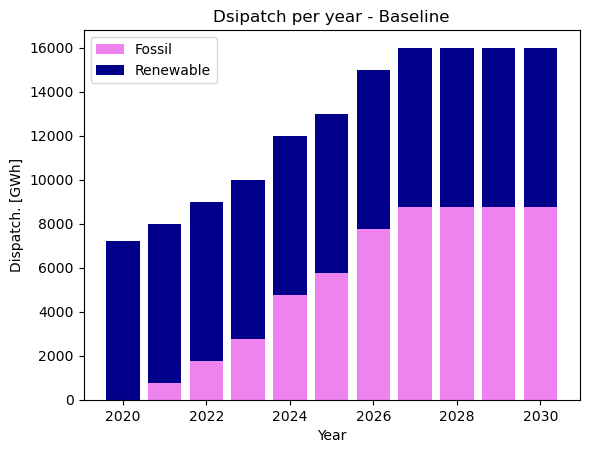

In [17]:
# Plot dispatch as bar chart
plt.bar(years, fossil_dispatch, color = 'violet', label = 'Fossil')
plt.bar(years, renewable_dispatch, bottom = fossil_dispatch, color = 'darkblue', label = 'Renewable')
plt.title('Dsipatch per year - Baseline')
plt.xlabel('Year')
plt.ylabel('Dispatch. [GWh]')
plt.legend()
plt.show()

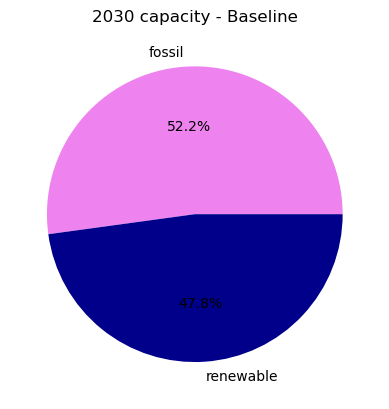

In [18]:
# Plot 2030 capacity as pie chart
capacity_2030 = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]
plt.pie(capacity_2030, labels = technologies, autopct='%1.1f%%', colors = ['violet', 'darkblue'])
plt.title('2030 capacity - Baseline')
plt.show()

### Carbon tax scenario

In [20]:
new_capacity_carbon, cumulative_capacity_carbon, dispatch_carbon, technologies_carbon, years_carbon = Carbon_Tax_Optimisation_Problem(TechnologiesDataFrame, YearsDataFrame, carbon_tax)

Model status:  Optimal
Optimised net present value of the electrical system is:  7171.48 m$ 

Renewable capacity in year 2030 is  7.61
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  12000.0
Fossil dispatch in 2030 is  4000.0 



In [21]:
# Generate variables for plotting graphics
fossil_dispatch_carbon = [pulp.value(dispatch_carbon[('fossil',y)]) for y in years]
renewable_dispatch_carbon = [pulp.value(dispatch_carbon[('renewable',y)]) for y in years]

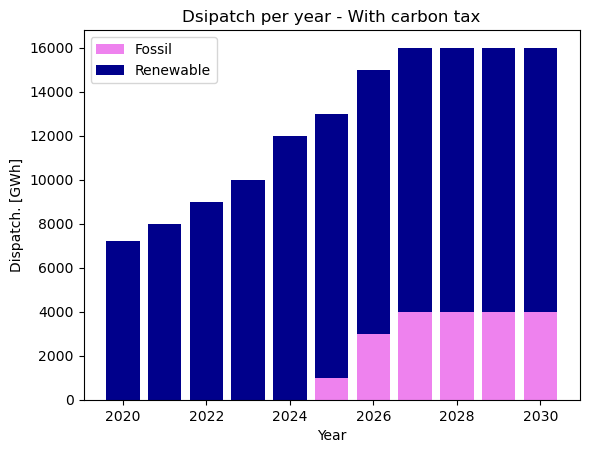

In [22]:
# Plot dispatch as bar chart
plt.bar(years_carbon, fossil_dispatch_carbon, color = 'violet', label = 'Fossil')
plt.bar(years_carbon, renewable_dispatch_carbon, bottom = fossil_dispatch_carbon, color = 'darkblue', label = 'Renewable')
plt.title('Dsipatch per year - With carbon tax')
plt.xlabel('Year')
plt.ylabel('Dispatch. [GWh]')
plt.legend()
plt.show()

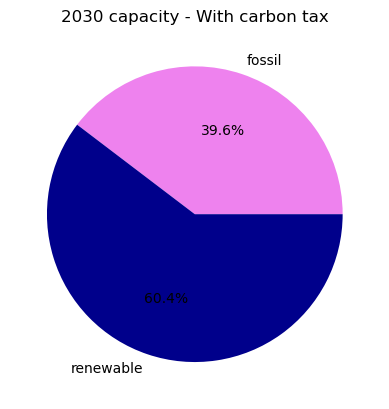

In [23]:
# Plot 2030 capacity as pie chart
capacity_2030_carbon = [pulp.value(cumulative_capacity_carbon[(t,2030)]) for t in technologies]
plt.pie(capacity_2030_carbon, labels = technologies_carbon, autopct='%1.1f%%', colors = ['violet', 'darkblue'])
plt.title('2030 capacity - With carbon tax')
plt.show()

### Land Limitation Scenario

In [36]:
new_capacity_land, cumulative_capacity_land, dispatch_land, technologies_land, years_land = Land_Optimisation_Problem(TechnologiesDataFrame, YearsDataFrame, carbon_tax)

NameError: name 'Land_Optimisation_Problem' is not defined

In [26]:
# Generate variables for plotting graphics
fossil_dispatch_land = [pulp.value(dispatch_land[('fossil',y)]) for y in years]
renewable_dispatch_land = [pulp.value(dispatch_land[('renewable',y)]) for y in years]

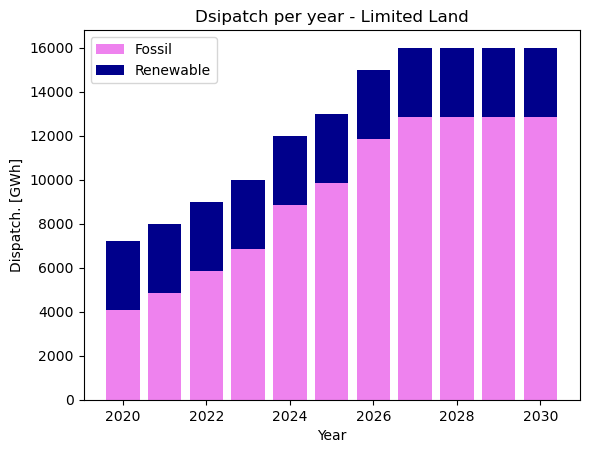

In [27]:
# Plot dispatch as bar chart
plt.bar(years_land, fossil_dispatch_land, color = 'violet', label = 'Fossil')
plt.bar(years_land, renewable_dispatch_land, bottom = fossil_dispatch_land, color = 'darkblue', label = 'Renewable')
plt.title('Dsipatch per year - Limited Land')
plt.xlabel('Year')
plt.ylabel('Dispatch. [GWh]')
plt.legend()
plt.show()

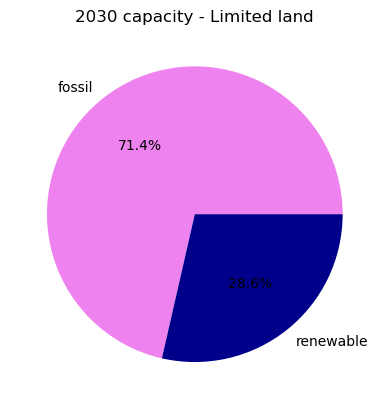

In [28]:
# Plot 2030 capacity as pie chart
capacity_2030_land = [pulp.value(cumulative_capacity_land[(t,2030)]) for t in technologies]
plt.pie(capacity_2030_land, labels = technologies_land, autopct='%1.1f%%', colors = ['violet', 'darkblue'])
plt.title('2030 capacity - Limited land')
plt.show()

### Renewables subsidy scenario

In [40]:
new_capacity_subsidy, cumulative_capacity_subsidy, dispatch_subsidy, technologies_subsidy, years_subsidy = Subsidy_Optimisation_Problem(TechnologiesDataFrame, YearsDataFrame, carbon_tax)

Model status:  Optimal
Optimised net present value of the electrical system is:  5745.13 m$ 

Renewable capacity in year 2030 is  6.34
Fossil capacity in 2030 is  5.0 

Renewable dispatch in year 2030 is  10000.0
Fossil dispatch in 2030 is  6000.0 



In [31]:
# Generate variables for plotting graphics
fossil_dispatch_subsidy = [pulp.value(dispatch_subsidy[('fossil',y)]) for y in years]
renewable_dispatch_subsidy = [pulp.value(dispatch_subsidy[('renewable',y)]) for y in years]

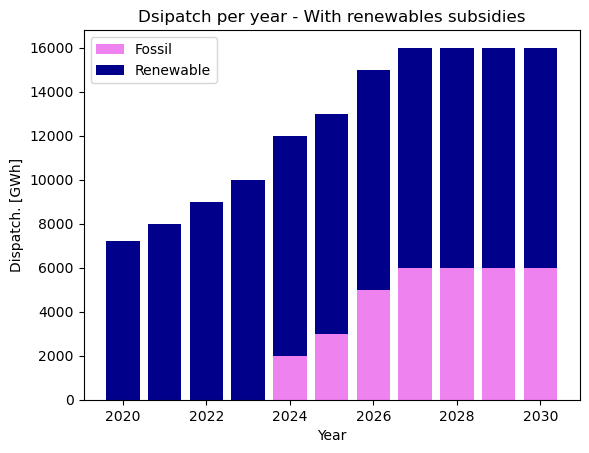

In [32]:
# Plot dispatch as bar chart
plt.bar(years_subsidy, fossil_dispatch_subsidy, color = 'violet', label = 'Fossil')
plt.bar(years_subsidy, renewable_dispatch_subsidy, bottom = fossil_dispatch_subsidy, color = 'darkblue', label = 'Renewable')
plt.title('Dsipatch per year - With renewables subsidies')
plt.xlabel('Year')
plt.ylabel('Dispatch. [GWh]')
plt.legend()
plt.show()

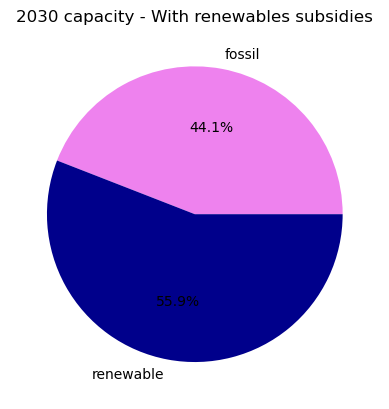

In [33]:
# Plot 2030 capacity as pie chart
capacity_2030_subsidy = [pulp.value(cumulative_capacity_subsidy[(t,2030)]) for t in technologies]
plt.pie(capacity_2030_subsidy, labels = technologies_subsidy, autopct='%1.1f%%', colors = ['violet', 'darkblue'])
plt.title('2030 capacity - With renewables subsidies')
plt.show()